# Ejercicio 6. *Loss Reserving* basado en triángulos *run-off* de pagos

## ChainLadder con Python
El método CL (van Eeghen, 1981) es un modelo matemático donde no se tiene en cuenta la incertidumbre a la hora de estimar la cuantía de los futuros pagos (en nuestro caso, el valor de la provisión monetaria a constituir).
La suposición del método CL es que los patrones de desarrollo de las pérdidas están basados en comportamientos históricos. Así, mostrando los datos de siniestros de forma bidimensional (matriz) bajo 2 características: fecha de ocurrencia y fecha de pago de los mismos. El objetivo es obtener el factor de crecimiento de los pagos (age-to-age factors) o link ratios.

## Pandas y NumPy

El primer paso consiste en importar los datos (10.000 siniestros ficticios desde 2013 al 2018) y mostramos los 10 primeros registros:

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('Siniestros.csv',sep=';')
data.head()

,Siniestro,Poliza,Fec_ocu,Fec_com,Fec_pago,Importe
0,1,31082,12-09-2016,21-09-2016,03-07-2017,83
1,2,61275,20-11-2017,03-01-2018,02-02-2018,71
2,3,72257,10-06-2013,25-06-2013,15-07-2013,115
3,4,73111,17-09-2013,05-10-2013,20-09-2018,67
4,5,84755,30-06-2017,12-07-2017,30-09-2017,122


Una vez importados los datos, modificamos los campos de fecha con el formato de fecha adecuado.

*Si formato original no fuera YYYY-MM-DD utilizar pd.to_datetime(data['Accident_Date'], format='%d-%m-%Y')*

In [2]:
data['Fec_ocu'] = pd.to_datetime(data['Fec_ocu'], format='%d-%m-%Y')
data['Fec_pago'] = pd.to_datetime(data['Fec_pago'], format='%d-%m-%Y')
data.head()

,Siniestro,Poliza,Fec_ocu,Fec_com,Fec_pago,Importe
0,1,31082,2016-09-12,21-09-2016,2017-07-03,83
1,2,61275,2017-11-20,03-01-2018,2018-02-02,71
2,3,72257,2013-06-10,25-06-2013,2013-07-15,115
3,4,73111,2013-09-17,05-10-2013,2018-09-20,67
4,5,84755,2017-06-30,12-07-2017,2017-09-30,122


Acto seguido, bien creamos nuevos campos con el año (ejemplo *Accident_Year*) o, como en este caso, modificamos dichos campos convertiendolos a una periocidad anual (utilizo la variable *freq* para posteriormente modificar la periodicidad facilmente).

In [3]:
freq='Y' 
data['Fec_ocu'] = data['Fec_ocu'].dt.to_period(freq=freq)
data['Fec_pago'] = data['Fec_pago'].dt.to_period(freq=freq)
data.head()

,Siniestro,Poliza,Fec_ocu,Fec_com,Fec_pago,Importe
0,1,31082,2016,21-09-2016,2017,83
1,2,61275,2017,03-01-2018,2018,71
2,3,72257,2013,25-06-2013,2013,115
3,4,73111,2013,05-10-2013,2018,67
4,5,84755,2017,12-07-2017,2017,122


Calculamos un nuevo campo llamado ‘Dev’ con el periodo de tiempo transcurrido (o desarrollo) como la diferencia entre ambos periodos (en este caso años) restandolos como números enteros: .astsype(int).
_Nota: el modo de restar dos fechas ha sido modificado en las últimas versiones (este ejercicio funciona en la version 1.5.2, en versiones anteriores de pandas se utilizaba .view(int)_

In [4]:
data['Dev'] = data['Fec_pago'].astype(int) - data['Fec_ocu'].astype(int)
data.head()

<ipython-input-4-91790b8e3948>:1: FutureWarning: The behavior of .astype from period[A-DEC] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  data['Dev'] = data['Fec_pago'].astype(int) - data['Fec_ocu'].astype(int)


,Siniestro,Poliza,Fec_ocu,Fec_com,Fec_pago,Importe,Dev
0,1,31082,2016,21-09-2016,2017,83,1
1,2,61275,2017,03-01-2018,2018,71,1
2,3,72257,2013,25-06-2013,2013,115,0
3,4,73111,2013,05-10-2013,2018,67,5
4,5,84755,2017,12-07-2017,2017,122,0


Agrupamos por año de accidente y año de desarrollo usando groupby(), y sumamos las cantidades de los siniestros:

In [5]:
datagg = data.groupby(['Fec_ocu','Dev']).agg({'Importe':'sum'}).reset_index()
datagg.head()

,Fec_ocu,Dev,Importe
0,2013,0,118066
1,2013,1,25877
2,2013,2,12392
3,2013,3,9743
4,2013,4,8599


Y una vez agrupados, guardamos los datos en una tabla 2-D (pivot table) basada en estas dos variables:

In [6]:
triangle = datagg.pivot(index='Fec_ocu',columns='Dev',values='Importe')
triangle

Dev,0,1,2,3,4,5
Fec_ocu,,,,,,
2013,118066.0,25877.0,12392.0,9743.0,8599.0,8977.0
2014,119961.0,26543.0,13813.0,11509.0,10339.0,NaN
2015,108140.0,27975.0,18551.0,14250.0,NaN,NaN
2016,107660.0,34826.0,19814.0,NaN,NaN,NaN
2017,112042.0,51641.0,NaN,NaN,NaN,NaN
2018,133511.0,NaN,NaN,NaN,NaN,NaN


A continuación, se calcula el triángulo con los pagos acumulados en el tiempo. Para acumular datos de un dataframe existe cumsum() aunque por defecto trabaja sumando las cifras de una columna, utilizando axis=1 logramos que sume filas.

Nota: en cualquier momento podemos hacer una exportación a csv o excel con la instrucción: *triangule.to_excel("triangule.xls")* o mostrarlo en pantalla con *print(triangule)*.

In [7]:
accumulate = triangle.cumsum(axis=1)
accumulate

Dev,0,1,2,3,4,5
Fec_ocu,,,,,,
2013,118066.0,143943.0,156335.0,166078.0,174677.0,183654.0
2014,119961.0,146504.0,160317.0,171826.0,182165.0,NaN
2015,108140.0,136115.0,154666.0,168916.0,NaN,NaN
2016,107660.0,142486.0,162300.0,NaN,NaN,NaN
2017,112042.0,163683.0,NaN,NaN,NaN,NaN
2018,133511.0,NaN,NaN,NaN,NaN,NaN


Ahora es el momento culminante, es decir, cuando se calcula el patrón de pagos o los factores de desarrollo: factores incrementales, link ratios o loss development factors (LDFs), y los factores acumulativos, final ratios o cumulative development factors (CDFs).

El cálculo en este paso es la principal diferencia entre los diferentes métodos basados en triángulos de run-off: exclusión de mínimos/máximos, medias, trabajando con las varianzas, covarianzas, remuestreos, distribuciones, regresiones GLM con Poisson, etc..

Espero que el código mostrado para un CL clásico sea suficientemente ilustrativo. Por comodidad, no he usado pd.Series() sino listas con unos que el *for* se encarga de alimentar. Suponemos que con el último pago se ha alcanzado el 100% de los pagos y no existen más datos en la cola.

In [8]:
n = len(accumulate)-1
LDFs = np.ones(n)

for i in range(n):
    SumDev = pd.Series(accumulate[i][:n-i]).sum(skipna=True)
    SumDevNext = pd.Series(accumulate[min(i+1,n)][:n-i]).sum(skipna=True)
    LDFs[i] = SumDevNext/SumDev

CDFs = np.ones(n+1)
for i in range(n):
    CDFs[i] = np.prod(LDFs[i:n])

In [9]:
LDFs, CDFs

(array([1.29487744, 1.11347022, 1.07532494, 1.0560455 , 1.051392  ]),
 array([1.7214495 , 1.32943045, 1.19395241, 1.11031779, 1.051392  ,
        1.        ]))

Con estos valores, calcular el **patrón de pagos** es fácil. La función reciprocal() devuelve el inverso del número (1/x). En la columna de ratios incrementales, reemplazo NaN por el valor de la columna de ratios accumulated ya que el primer valor de diff() siempre es NaN.

<AxesSubplot: >

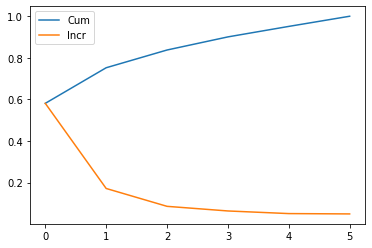

In [10]:
payment_pattern = pd.DataFrame(data=np.reciprocal(CDFs),columns=['Cum'])
payment_pattern['Incr'] = payment_pattern['Cum'].diff().fillna(payment_pattern['Cum']) #First value of diff() is always NaN
payment_pattern.plot()

Ahora, tan solo multiplicando pagos y ratios finales de desarrollo (al último valor) obtenemos el valor del pago último, que restando los pagos actuales obtenemos el valor de la reserva monetaria a constituir.

Para calcular el importe de los pagos actuales tenemos dos opciones: 
a) sumar horizontalmente (axis=1) el triángulo incremental, 
b) obtener la diagonal del triángulo acumulado. 

Aunque la primera opción es más fácil: *triangule.sum(axis=1, skipna=True).sum()* he querido utilizar la función diag() de numpy a efectos ilustrativos de las posibilidades de panda (flipud sirve para girar el triángulo ya que por defecto la función diagonal devuelve la diagonal empezando por [0,0] y acabando en [n,n].)

In [11]:
diagonal = np.diag(np.flipud(accumulate))
payments = pd.Series(data=diagonal)
payments

0    133511.0
1    163683.0
2    162300.0
3    168916.0
4    182165.0
5    183654.0
dtype: float64

Cálculo del ultimate:

In [12]:
ultimate = np.vdot(CDFs, payments).round(2)
ultimate

1203947.35

Cálculo de la reserva:

In [13]:
reserve = (ultimate - np.sum(payments)).round(2)
reserve

209718.35

## Frecuencia
¿Queremos calcular los ratios con información agrupada de forma trimestrales en vez de anuales? Si bien esto puede ser una ardua tarea si tenemos nuestros triángulos en Excel, en el código visto previamente tan solo habría que cambiar la variable 'Y' a 'Q'.

El listado de valores posibles para el atributo freq se puede consultar en la documentación de timeseries [https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases] de panda: 

* Y: year end frequency
* Q: quarter end frequency
* M: month end frequency
* W: weekly frequency

## Selector de factores

Es bastante común, al calcular los factores, hacer una selección excluyendo los máximos y mínimos, o lo que sea que un juicio experto considere.

En este caso, podemos crear un DataFrame de datos para hacer el cálculo de los factores, y operar como sea necesario, por ejemplo, ordenandolos para excluir los factores primero y último:

In [14]:
LDFs = np.ones(n)

for i in range(n):
    SumDev = pd.Series(accumulate[i], name='SumDev')
    SumDevNext = pd.Series(accumulate[i+1], name='SumDevNext')
    LDF_w = pd.concat([SumDev, SumDevNext], axis=1)[:-i-1]
    LDF_w['Perc'] = LDF_w['SumDevNext'] / LDF_w['SumDev']
    datasort = LDF_w.sort_values(by=['Perc'])
    if len(datasort) > 2:
        ratio = datasort[1:-1]['SumDevNext'].sum()/datasort[1:-1]['SumDev'].sum()
    else:
        ratio = datasort['SumDevNext'].sum()/datasort['SumDev'].sum()
    LDFs[i] = ratio

## Resultados

| Freq | F. Select?  | Importe|
|------|------|------|
|  Y  |  No   | 209.718,35 |
|  Q  |  No   | 215.174,03 |
|  Y  |  Yes  | 202.931,33 |
|  Q  |  Yes  | 210.891,32

## Exportacion
El triángulo exportado a csv o Excel tendría este aspecto:

![title](triangulo_acumulado.png)